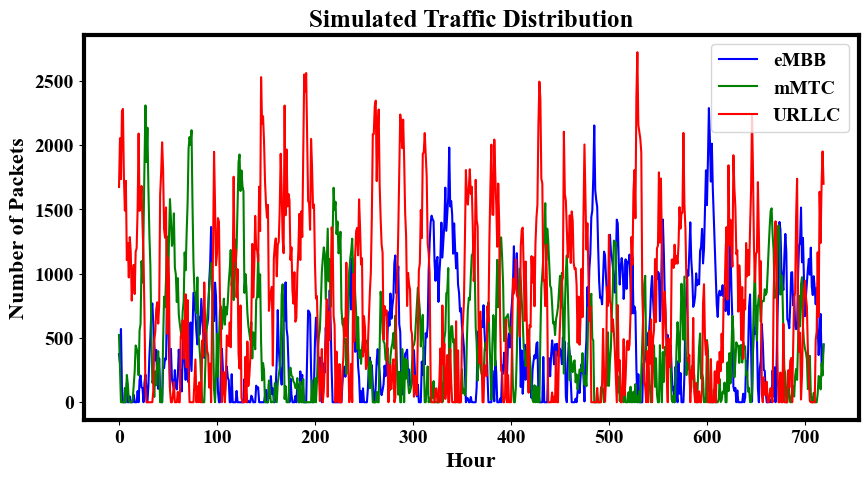

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['font.weight'] = "bold"

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = "bold"
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'

def generate_traffic(hour, peak_hour, base_traffic, peak_factor=2.0, variation=0.1):
    sine_wave = np.sin(np.pi * (hour - peak_hour) / 12) + 1
    mean_traffic = base_traffic * (1 + (peak_factor - 1) * sine_wave / 2)
    total_packets = int(np.clip(np.random.normal(mean_traffic, variation * base_traffic), 0, None))
    return total_packets

def correlate_traffic(total_packets, previous_slices, max_variation=0.2):
    max_change = int(total_packets * max_variation)
    slice1_packets = np.clip(previous_slices[0] + random.randint(-max_change, max_change), 0, total_packets)
    remaining_packets = total_packets - slice1_packets
    slice2_packets = np.clip(previous_slices[1] + random.randint(-max_change, max_change), 0, remaining_packets)
    slice3_packets = remaining_packets - slice2_packets
    return slice1_packets, slice2_packets, slice3_packets

def simulate_traffic(base_traffic, peak_hour, iterations, peak_factor=2.0, variation=0.1, max_variation=0.2):
    traffic_data = []
    previous_slices = (base_traffic // 2, base_traffic // 4, base_traffic // 4)
    for hour in range(iterations):
        total_packets = generate_traffic(hour % 24, peak_hour, base_traffic, peak_factor, variation)
        slice1_packets, slice2_packets, slice3_packets = correlate_traffic(total_packets, previous_slices, max_variation)
        traffic_data.append({"eMBB": slice1_packets, "mMTC": slice2_packets, "URLLC": slice3_packets})
        previous_slices = (slice1_packets, slice2_packets, slice3_packets)
    return traffic_data

def plot_traffic_distribution(traffic_data):
    embb_traffic = [data["eMBB"] for data in traffic_data]
    mmtc_traffic = [data["mMTC"] for data in traffic_data]
    urllc_traffic = [data["URLLC"] for data in traffic_data]
    
    plt.figure(figsize=(10, 5))
    plt.plot(embb_traffic, label="eMBB", color='blue')
    plt.plot(mmtc_traffic, label="mMTC", color='green')
    plt.plot(urllc_traffic, label="URLLC", color='red')
    plt.xlabel('Hour')
    plt.ylabel('Number of Packets')
    plt.title('Simulated Traffic Distribution')
    plt.legend()
    plt.show()

# Parameters
base_traffic = 1000  # Base traffic volume for off-peak hours
peak_hour = 18  # Hour of peak traffic (6 PM)
iterations = 24 * 30  # Number of iterations to simulate (30 days)
peak_factor = 2.5  # Peak traffic factor
variation = 0.2  # Standard deviation for random variation
max_variation = 0.2  # Maximum allowable variation in traffic

# Simulate traffic
traffic_data = simulate_traffic(base_traffic, peak_hour, iterations, peak_factor, variation, max_variation)

# Plot the traffic distribution
plot_traffic_distribution(traffic_data)


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

traffic_df = pd.DataFrame(traffic_data)

# Separate traffic data for each slice
embb_traffic = traffic_df['eMBB'].values.reshape(-1, 1)
mmtc_traffic = traffic_df['mMTC'].values.reshape(-1, 1)
urllc_traffic = traffic_df['URLLC'].values.reshape(-1, 1)

# Normalize the data for each slice
scaler_embb = MinMaxScaler()
scaler_mmtc = MinMaxScaler()
scaler_urllc = MinMaxScaler()

embb_traffic_normalized = scaler_embb.fit_transform(embb_traffic)
mmtc_traffic_normalized = scaler_mmtc.fit_transform(mmtc_traffic)
urllc_traffic_normalized = scaler_urllc.fit_transform(urllc_traffic)

# Create sequences for LSTM training for each slice
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequence_length = 24  # Use 24 hours as the sequence length

# Create sequences for eMBB slice
X_embb = create_sequences(embb_traffic_normalized, sequence_length)
y_embb = embb_traffic_normalized[sequence_length:]

# Create sequences for mMTC slice
X_mmtc = create_sequences(mmtc_traffic_normalized, sequence_length)
y_mmtc = mmtc_traffic_normalized[sequence_length:]

# Create sequences for URLLC slice
X_urllc = create_sequences(urllc_traffic_normalized, sequence_length)
y_urllc = urllc_traffic_normalized[sequence_length:]

# Split the data into training and testing sets for each slice
X_embb_train, X_embb_test, y_embb_train, y_embb_test = train_test_split(X_embb, y_embb, test_size=0.2, random_state=42)
X_mmtc_train, X_mmtc_test, y_mmtc_train, y_mmtc_test = train_test_split(X_mmtc, y_mmtc, test_size=0.2, random_state=42)
X_urllc_train, X_urllc_test, y_urllc_train, y_urllc_test = train_test_split(X_urllc, y_urllc, test_size=0.2, random_state=42)

In [3]:
# Function to plot training history
def plot_training_history(history, slice_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {slice_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0529 - val_loss: 0.0322
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0260 - val_loss: 0.0279
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219 - val_loss: 0.0262
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0179 - val_loss: 0.0241
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0152 - val_loss: 0.0197
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0180 - val_loss: 0.0211
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - val_loss: 0.0195
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146 - val_loss: 0.0165
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - val_loss: 0.0176
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - val_loss: 0.0151
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - val_loss: 0.0163
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141 - val_loss: 0.0139

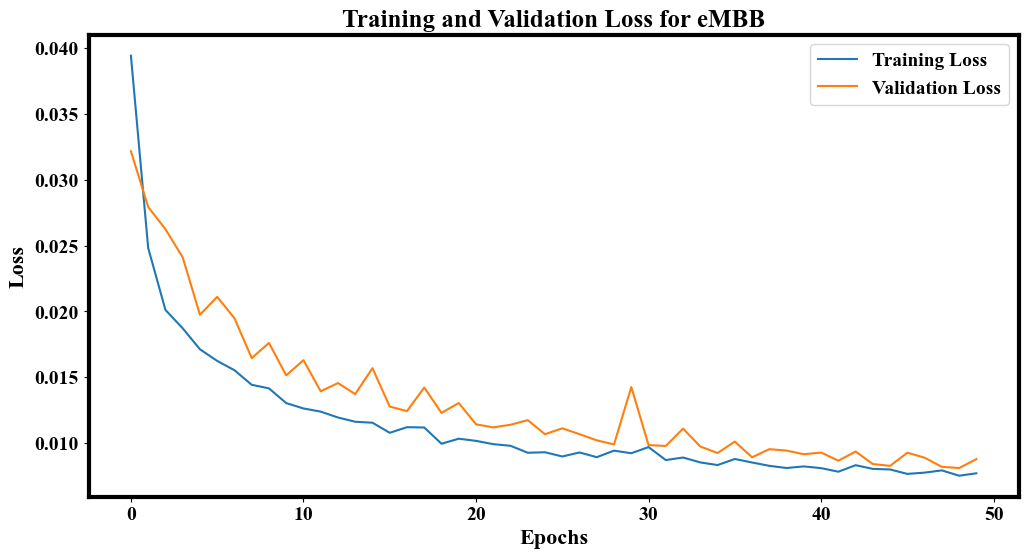

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model for eMBB slice
model_embb = Sequential()
model_embb.add(LSTM(50, return_sequences=True, input_shape=(X_embb_train.shape[1], X_embb_train.shape[2])))
model_embb.add(Dropout(0.2))
model_embb.add(LSTM(50, return_sequences=False))
model_embb.add(Dropout(0.2))
model_embb.add(Dense(1))  # One output neuron for eMBB
model_embb.compile(optimizer='adam', loss='mse')

# Train the LSTM model for eMBB slice
history_embb = model_embb.fit(X_embb_train, y_embb_train, epochs=50, batch_size=32, validation_split=0.2)

plot_training_history(history_embb, 'eMBB')


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0579 - val_loss: 0.0313
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0312 - val_loss: 0.0286
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0275 - val_loss: 0.0263
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0264 - val_loss: 0.0245
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0229 - val_loss: 0.0225
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0229 - val_loss: 0.0208
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0214 - val_loss: 0.0194
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0207 - val_loss: 0.0174
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0184 - val_loss: 0.0161
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - val_loss: 0.0154
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - val_l

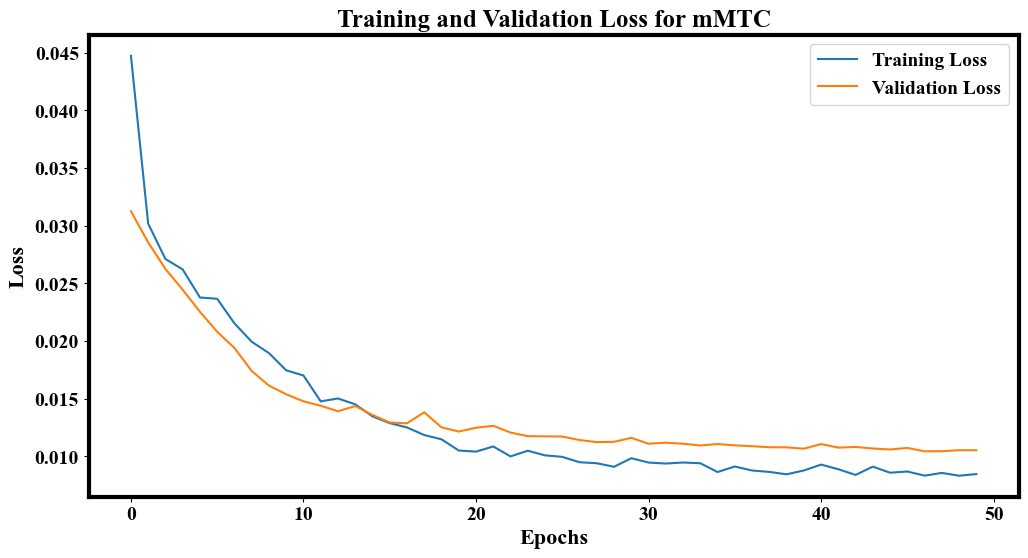

In [5]:

# Build the LSTM model for mMTC slice
model_mmtc = Sequential()
model_mmtc.add(LSTM(50, return_sequences=True, input_shape=(X_mmtc_train.shape[1], X_mmtc_train.shape[2])))
model_mmtc.add(Dropout(0.2))
model_mmtc.add(LSTM(50, return_sequences=False))
model_mmtc.add(Dropout(0.2))
model_mmtc.add(Dense(1))  # One output neuron for mMTC
model_mmtc.compile(optimizer='adam', loss='mse')

# Train the LSTM model for mMTC slice
history_mmtc = model_mmtc.fit(X_mmtc_train, y_mmtc_train, epochs=50, batch_size=32, validation_split=0.2)

plot_training_history(history_mmtc, 'mMTC')

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0905 - val_loss: 0.0543
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0528 - val_loss: 0.0481
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0488 - val_loss: 0.0443
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0429 - val_loss: 0.0405
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0387 - val_loss: 0.0358
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0358 - val_loss: 0.0309
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0318 - val_loss: 0.0273
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0266 - val_loss: 0.0247
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0269 - val_loss: 0.0243
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0236 - val_loss: 0.0232
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0227 - val_loss: 0.0223
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0228 - val_l

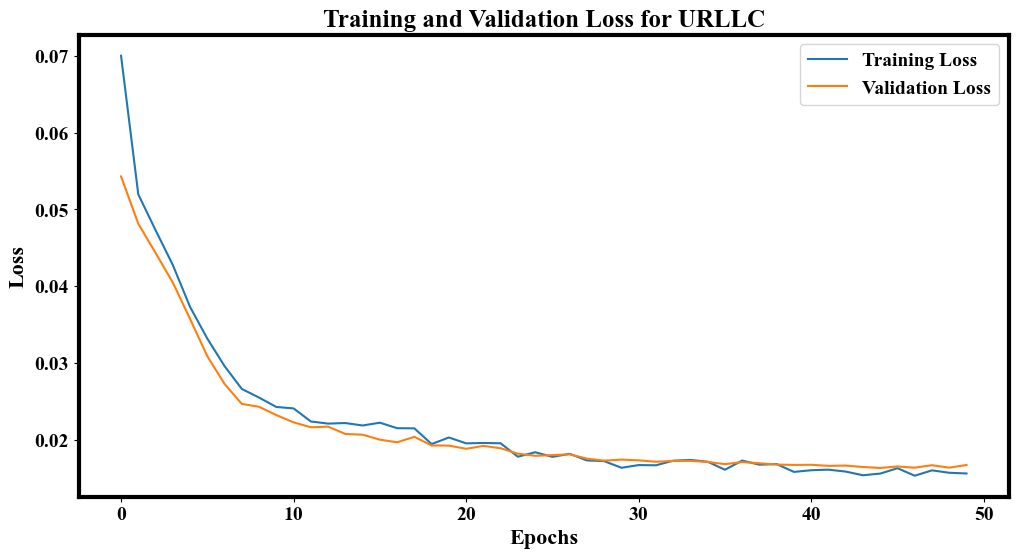

In [6]:
# Build the LSTM model for URLLC slice
model_urllc = Sequential()
model_urllc.add(LSTM(50, return_sequences=True, input_shape=(X_urllc_train.shape[1], X_urllc_train.shape[2])))
model_urllc.add(Dropout(0.2))
model_urllc.add(LSTM(50, return_sequences=False))
model_urllc.add(Dropout(0.2))
model_urllc.add(Dense(1))  # One output neuron for URLLC
model_urllc.compile(optimizer='adam', loss='mse')

# Train the LSTM model for URLLC slice
history_urllc = model_urllc.fit(X_urllc_train, y_urllc_train, epochs=50, batch_size=32, validation_split=0.2)

plot_training_history(history_urllc, 'URLLC')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


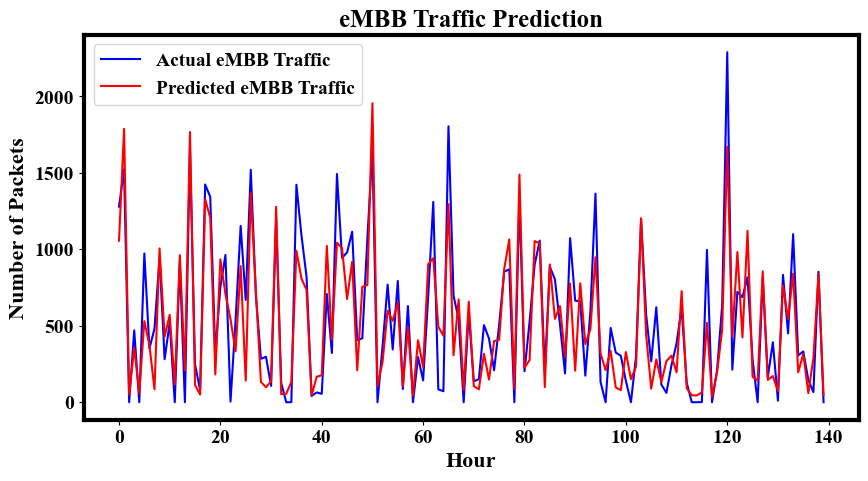

In [7]:
# Function to plot predictions
def plot_predictions(y_true, y_pred, slice_name):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label=f"Actual {slice_name} Traffic", color='blue')
    plt.plot(y_pred, label=f"Predicted {slice_name} Traffic", color='red')
    plt.xlabel('Hour')
    plt.ylabel('Number of Packets')
    plt.title(f'{slice_name} Traffic Prediction')
    plt.legend()
    plt.show()

# Predictions for eMBB slice
y_embb_pred = model_embb.predict(X_embb_test)
y_embb_true = scaler_embb.inverse_transform(y_embb_test)
y_embb_pred_inv = scaler_embb.inverse_transform(y_embb_pred)

# Plot predictions for eMBB slice
plot_predictions(y_embb_true, y_embb_pred_inv, 'eMBB')


In [8]:
mse_value_embb = model_embb.evaluate(X_embb_test, y_embb_test)
mse_value_embb

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 


0.008652259595692158

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


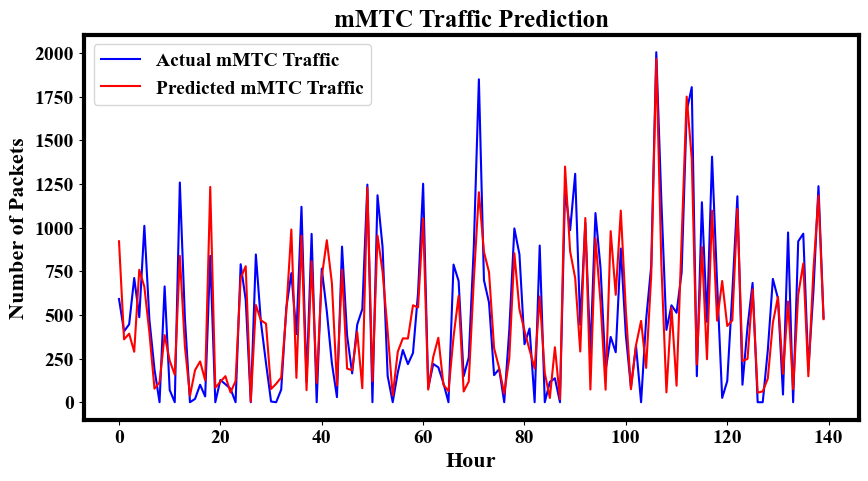

In [9]:
# Predictions for mMTC slice
y_mmtc_pred = model_mmtc.predict(X_mmtc_test)
y_mmtc_true = scaler_mmtc.inverse_transform(y_mmtc_test)
y_mmtc_pred_inv = scaler_mmtc.inverse_transform(y_mmtc_pred)

# Plot predictions for mMTC slice
plot_predictions(y_mmtc_true, y_mmtc_pred_inv, 'mMTC')


In [10]:
mse_value_mmtc = model_mmtc.evaluate(X_mmtc_test, y_mmtc_test)
mse_value_mmtc

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 


0.009218188002705574

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x316656020> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


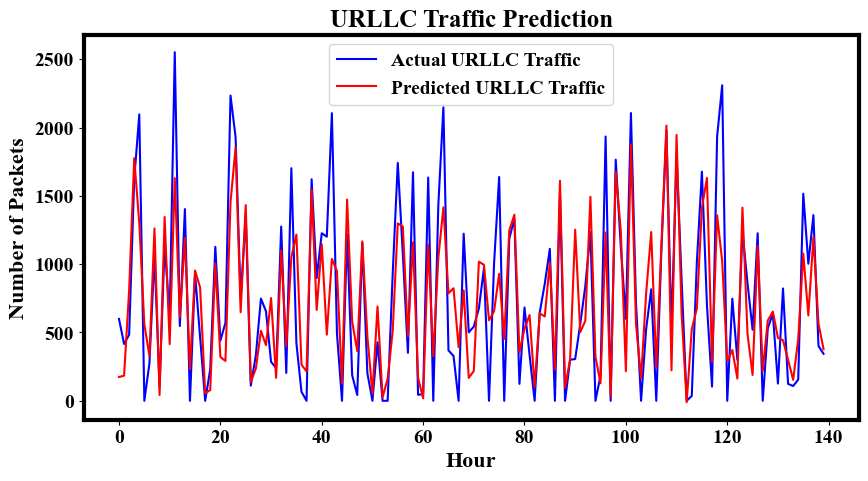

In [11]:
# Predictions for URLLC slice
y_urllc_pred = model_urllc.predict(X_urllc_test)
y_urllc_true = scaler_urllc.inverse_transform(y_urllc_test)
y_urllc_pred_inv = scaler_urllc.inverse_transform(y_urllc_pred)

# Plot predictions for URLLC slice
plot_predictions(y_urllc_true, y_urllc_pred_inv, 'URLLC')

In [12]:
mse_value_urllc = model_urllc.evaluate(X_urllc_test, y_urllc_test)
mse_value_urllc

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 


0.017929663881659508

In [14]:
import numpy as np

# Define resource allocation functions
def allocate_resources(traffic_volume, bandwidth_per_packet, latency_tolerance, memory_per_packet):
    total_bandwidth = traffic_volume * bandwidth_per_packet
    total_memory = traffic_volume * memory_per_packet
    # Assuming the latency tolerance directly impacts the latency resources required
    latency_resources = latency_tolerance / traffic_volume if traffic_volume > 0 else latency_tolerance
    return total_bandwidth, latency_resources, total_memory

# Define QoS metrics for each slice
bandwidth_per_packet = {'eMBB': 2, 'mMTC': 0.5, 'URLLC': 1}  # Example values in Mbps
latency_tolerance = {'eMBB': 50, 'mMTC': 200, 'URLLC': 10}   # Example values in ms
memory_per_packet = {'eMBB': 1, 'mMTC': 0.2, 'URLLC': 0.5}   # Example values in MB

# Allocate resources based on predicted traffic volumes
def resource_allocation(y_pred_inv, slice_name):
    total_bandwidth, total_latency, total_memory = 0, 0, 0
    for traffic_volume in y_pred_inv:
        bw, latency, memory = allocate_resources(traffic_volume, 
                                                 bandwidth_per_packet[slice_name], 
                                                 latency_tolerance[slice_name], 
                                                 memory_per_packet[slice_name])
        total_bandwidth += bw
        total_latency += latency
        total_memory += memory
    return total_bandwidth, total_latency, total_memory

# Predicted traffic volumes from the LSTM models (example data)
# y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv

# Calculate resources for each slice
resources_embb = resource_allocation(y_embb_pred_inv, 'eMBB')
resources_mmtc = resource_allocation(y_mmtc_pred_inv, 'mMTC')
resources_urllc = resource_allocation(y_urllc_pred_inv, 'URLLC')

# Print allocated resources
print(f"eMBB Slice - Total Bandwidth: {resources_embb[0]} Mbps, Total Latency: {resources_embb[1]} ms, Total Memory: {resources_embb[2]} MB")
print(f"mMTC Slice - Total Bandwidth: {resources_mmtc[0]} Mbps, Total Latency: {resources_mmtc[1]} ms, Total Memory: {resources_mmtc[2]} MB")
print(f"URLLC Slice - Total Bandwidth: {resources_urllc[0]} Mbps, Total Latency: {resources_urllc[1]} ms, Total Memory: {resources_urllc[2]} MB")

eMBB Slice - Total Bandwidth: [142414.52] Mbps, Total Latency: [36.60192] ms, Total Memory: [71207.26] MB
mMTC Slice - Total Bandwidth: [33441.664] Mbps, Total Latency: [210.02524] ms, Total Memory: [13376.664] MB
URLLC Slice - Total Bandwidth: [101122.98] Mbps, Total Latency: [15.058895] ms, Total Memory: [50561.49] MB


In [15]:
import numpy as np

# Function to dynamically allocate resources
def dynamic_resource_allocation(traffic_volume, prev_allocation, slice_name):
    # Define dynamic adjustment factors
    adjustment_factor_bandwidth = 0.1
    adjustment_factor_latency = 0.1
    adjustment_factor_memory = 0.1
    
    # Calculate base resource needs
    base_bandwidth, base_latency, base_memory = allocate_resources(traffic_volume, 
                                                                   bandwidth_per_packet[slice_name], 
                                                                   latency_tolerance[slice_name], 
                                                                   memory_per_packet[slice_name])
    
    # Adjust resources dynamically based on previous allocation
    new_bandwidth = prev_allocation[0] + adjustment_factor_bandwidth * (base_bandwidth - prev_allocation[0])
    new_latency = prev_allocation[1] + adjustment_factor_latency * (base_latency - prev_allocation[1])
    new_memory = prev_allocation[2] + adjustment_factor_memory * (base_memory - prev_allocation[2])
    
    return new_bandwidth, new_latency, new_memory

# Function to process predictions and allocate resources dynamically
def process_predictions_and_allocate_resources(y_pred_inv, slice_name):
    time_steps = 50
    resource_allocations = []
    
    # Initial resource allocation
    prev_allocation = (0, 0, 0)
    
    for i in range(0, len(y_pred_inv), time_steps):
        # Get the current window of predictions
        current_window = y_pred_inv[i:i + time_steps]
        
        # Calculate the total traffic volume for the current window
        total_traffic_volume = np.sum(current_window)
        
        # Allocate resources dynamically
        new_allocation = dynamic_resource_allocation(total_traffic_volume, prev_allocation, slice_name)
        
        # Store the new allocation
        resource_allocations.append(new_allocation)
        
        # Update the previous allocation
        prev_allocation = new_allocation
    
    return resource_allocations

# Simulated predicted traffic volumes for 200 time steps (example data)
y_embb_pred_inv = np.random.randint(100, 200, 200)  # Example traffic predictions
y_mmtc_pred_inv = np.random.randint(10, 50, 200)    # Example traffic predictions
y_urllc_pred_inv = np.random.randint(50, 100, 200)  # Example traffic predictions

# Process predictions and allocate resources dynamically
resources_embb = process_predictions_and_allocate_resources(y_embb_pred_inv, 'eMBB')
resources_mmtc = process_predictions_and_allocate_resources(y_mmtc_pred_inv, 'mMTC')
resources_urllc = process_predictions_and_allocate_resources(y_urllc_pred_inv, 'URLLC')

# Print allocated resources for the first few time windows
print("eMBB Resource Allocations (First 5):", resources_embb[:5])
print("mMTC Resource Allocations (First 5):", resources_mmtc[:5])
print("URLLC Resource Allocations (First 5):", resources_urllc[:5])

eMBB Resource Allocations (First 5): [(1534.4, 0.0006517205422314912, 767.2), (2800.5600000000004, 0.0012909722693552005, 1400.2800000000002), (4059.1040000000003, 0.0018118165476842067, 2029.5520000000001), (5147.5936, 0.0022997997751427668, 2573.7968)]
mMTC Resource Allocations (First 5): [(71.7, 0.013947001394700141, 28.680000000000003), (137.88, 0.026185566422237627, 55.15200000000001), (194.84199999999998, 0.03770128539838842, 77.9368), (247.2078, 0.04784904134010838, 98.88312)]
URLLC Resource Allocations (First 5): [(363.3, 0.0002752546105147261, 181.65), (695.37, 0.0005191732319822546, 347.685), (1003.7330000000001, 0.0007318761786967046, 501.86650000000003), (1266.6597000000002, 0.0009339431713417602, 633.3298500000001)]


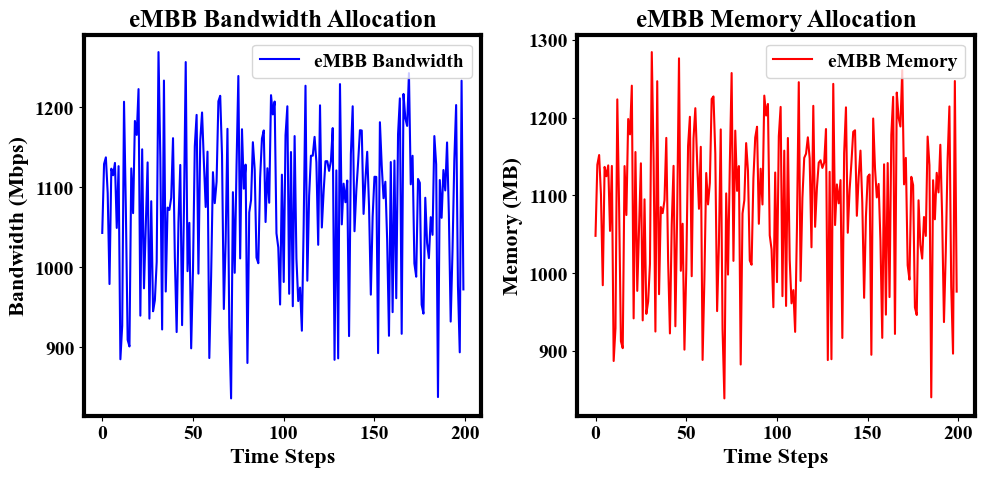

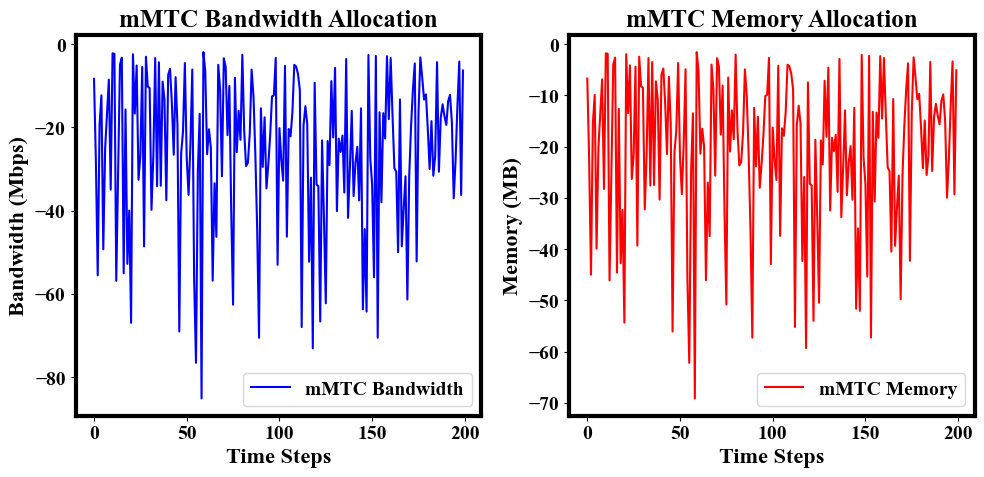

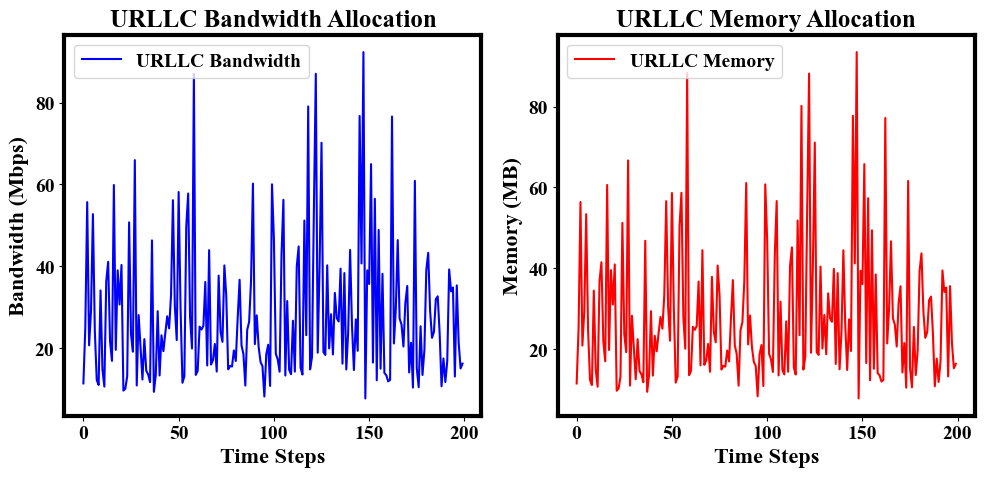

In [16]:
import numpy as np

# Define resource constraints
total_bandwidth = 1000  # Total available bandwidth in Mbps
total_latency = 1000    # Total available latency in ms (lower is better)
total_memory = 1000     # Total available memory in MB

# Define utility functions for each slice
def utility_embb(bandwidth, latency, memory):
    return (0.6 * bandwidth - 0.2 * latency + 0.2 * memory)

def utility_mmtc(bandwidth, latency, memory):
    return (0.2 * bandwidth - 0.5 * latency + 0.3 * memory)

def utility_urllc(bandwidth, latency, memory):
    return (0.3 * bandwidth - 0.6 * latency + 0.1 * memory)

# Function to normalize allocations
def normalize_allocations(allocations, total_resources):
    total_alloc = sum(allocations)
    if total_alloc == 0:
        return [0] * len(allocations)
    return [(alloc / total_alloc) * total_resources for alloc in allocations]

# Function to allocate resources using game theory
def allocate_resources_game_theory(y_pred_inv_embb, y_pred_inv_mmtc, y_pred_inv_urllc):
    time_steps = len(y_pred_inv_embb)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}

    for t in range(time_steps):
        traffic_embb = y_pred_inv_embb[t]
        traffic_mmtc = y_pred_inv_mmtc[t]
        traffic_urllc = y_pred_inv_urllc[t]
        
        # Initial allocation requests based on traffic volume
        req_bandwidth = [traffic_embb * 2, traffic_mmtc * 0.5, traffic_urllc * 1]
        req_latency = [traffic_embb * 50, traffic_mmtc * 200, traffic_urllc * 10]
        req_memory = [traffic_embb * 1, traffic_mmtc * 0.2, traffic_urllc * 0.5]

        # Normalize requests
        alloc_bandwidth = normalize_allocations(req_bandwidth, total_bandwidth)
        alloc_latency = normalize_allocations(req_latency, total_latency)
        alloc_memory = normalize_allocations(req_memory, total_memory)
        
        # Compute utilities
        utilities = [
            utility_embb(alloc_bandwidth[0], alloc_latency[0], alloc_memory[0]),
            utility_mmtc(alloc_bandwidth[1], alloc_latency[1], alloc_memory[1]),
            utility_urllc(alloc_bandwidth[2], alloc_latency[2], alloc_memory[2])
        ]
        
        # Adjust allocations based on utilities
        sum_utilities = sum(utilities)
        if sum_utilities > 0:
            alloc_bandwidth = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_bandwidth, utilities)]
            alloc_latency = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_latency, utilities)]
            alloc_memory = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_memory, utilities)]
        
        # Store allocations
        resource_allocations['eMBB'].append((alloc_bandwidth[0], alloc_latency[0], alloc_memory[0]))
        resource_allocations['mMTC'].append((alloc_bandwidth[1], alloc_latency[1], alloc_memory[1]))
        resource_allocations['URLLC'].append((alloc_bandwidth[2], alloc_latency[2], alloc_memory[2]))
    
    return resource_allocations

# Example traffic predictions for 200 time steps
np.random.seed(42)  # For reproducible results
y_embb_pred_inv = np.random.randint(100, 200, 200)
y_mmtc_pred_inv = np.random.randint(10, 50, 200)
y_urllc_pred_inv = np.random.randint(50, 100, 200)

# Allocate resources using game theory
resource_allocations = allocate_resources_game_theory(y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv)

# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    latency_allocations = [alloc[1] for alloc in resource_allocations]
    memory_allocations = [alloc[2] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))
    
    plt.figure(figsize=(15, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 3, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # # Plot latency allocations
    # plt.subplot(1, 3, 2)
    # plt.plot(time_steps, latency_allocations, label=f"{slice_name} Latency", color='green')
    # plt.xlabel('Time Steps')
    # plt.ylabel('Latency (ms)')
    # plt.title(f'{slice_name} Latency Allocation')
    # plt.legend()

    # Plot memory allocations
    plt.subplot(1, 3, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations
plot_resource_allocations(resource_allocations['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations['URLLC'], 'URLLC')

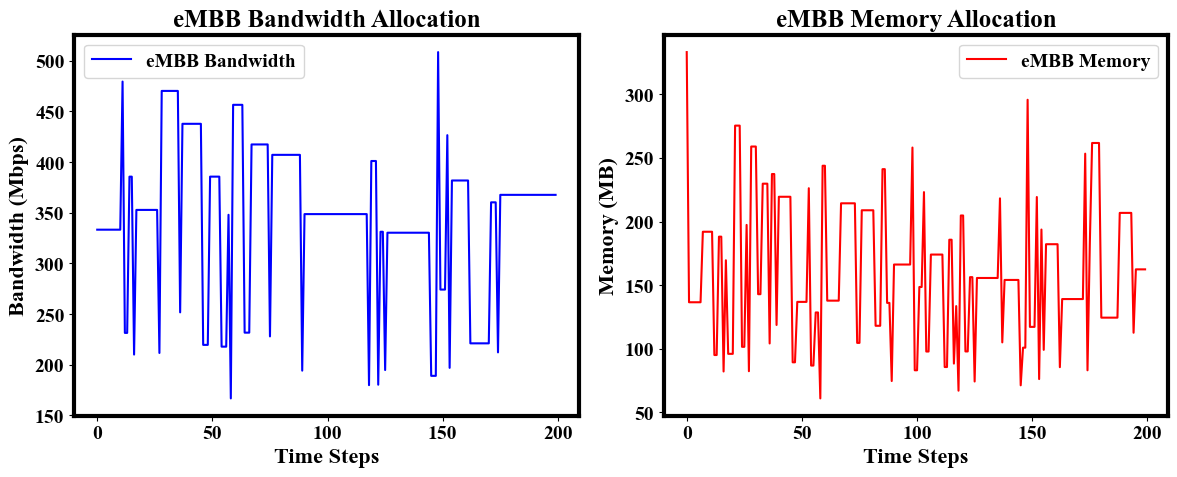

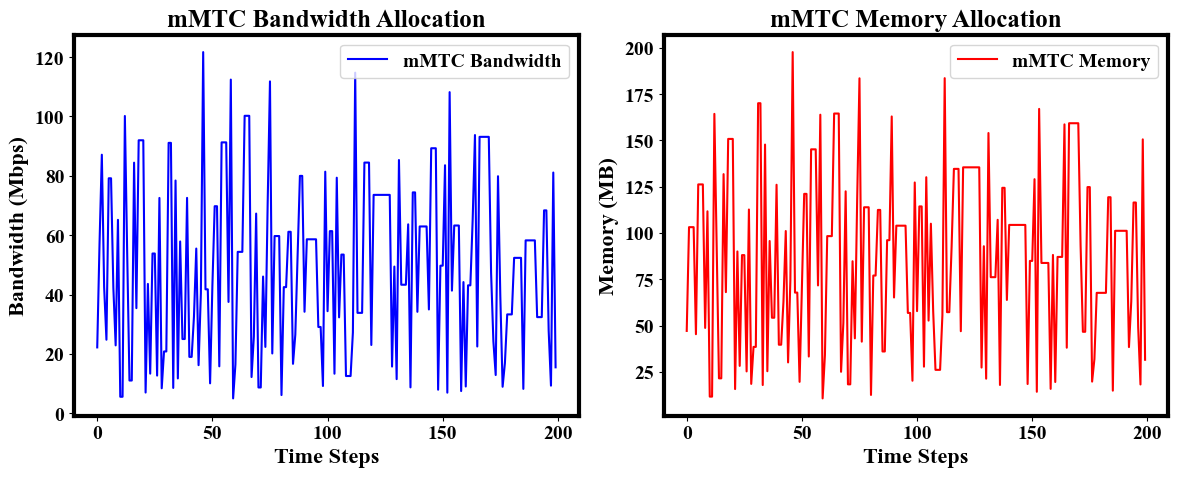

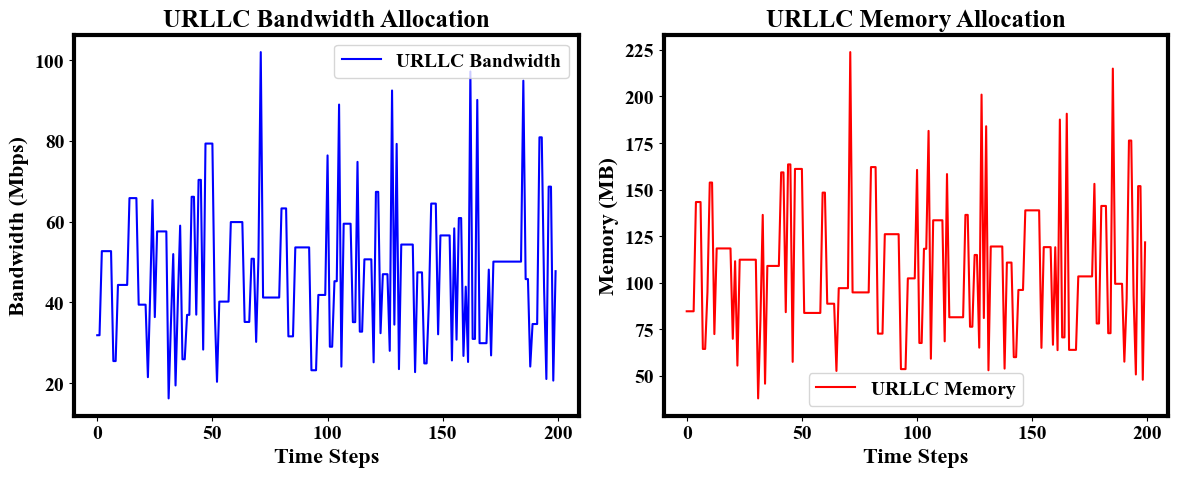

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Define resource constraints
total_bandwidth = 1000  # Total available bandwidth in Mbps
total_memory = 1000     # Total available memory in MB

# Define utility functions for each slice
def utility_embb(bandwidth, memory):
    return (0.6 * bandwidth + 0.4 * memory)

def utility_mmtc(bandwidth, memory):
    return (0.2 * bandwidth + 0.8 * memory)

def utility_urllc(bandwidth, memory):
    return (0.5 * bandwidth + 0.5 * memory)

# Function to normalize allocations
def normalize_allocations(allocations, total_resources):
    total_alloc = sum(allocations)
    if total_alloc == 0:
        return [0] * len(allocations)
    return [(alloc / total_alloc) * total_resources for alloc in allocations]

# Function to smooth allocations
def smooth_allocation(current, new, threshold=0.4):
    if abs(new - current) / current > threshold:
        return new
    return current

# Function to allocate resources using game theory with smoothing
def allocate_resources_game_theory(y_pred_inv_embb, y_pred_inv_mmtc, y_pred_inv_urllc):
    time_steps = len(y_pred_inv_embb)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}

    # Initial resource allocation
    prev_alloc_bandwidth = [total_bandwidth / 3] * 3
    prev_alloc_memory = [total_memory / 3] * 3

    for t in range(time_steps):
        traffic_embb = y_pred_inv_embb[t]
        traffic_mmtc = y_pred_inv_mmtc[t]
        traffic_urllc = y_pred_inv_urllc[t]
        
        # Initial allocation requests based on traffic volume
        req_bandwidth = [traffic_embb * 0.4, traffic_mmtc * 0.5, traffic_urllc * 0.2]
        req_memory = [traffic_embb * 0.2, traffic_mmtc * 1, traffic_urllc * 0.5]

        # Normalize requests
        alloc_bandwidth = normalize_allocations(req_bandwidth, total_bandwidth)
        alloc_memory = normalize_allocations(req_memory, total_memory)
        
        # Compute utilities
        utilities = [
            utility_embb(alloc_bandwidth[0], alloc_memory[0]),
            utility_mmtc(alloc_bandwidth[1], alloc_memory[1]),
            utility_urllc(alloc_bandwidth[2], alloc_memory[2])
        ]
        
        # Adjust allocations based on utilities
        sum_utilities = sum(utilities)
        if sum_utilities > 0:
            alloc_bandwidth = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_bandwidth, utilities)]
            alloc_memory = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_memory, utilities)]
        
        # Smooth allocations
        smooth_bandwidth = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_bandwidth, alloc_bandwidth)]
        smooth_memory = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_memory, alloc_memory)]
        
        # Store allocations
        resource_allocations['eMBB'].append((smooth_bandwidth[0], smooth_memory[0]))
        resource_allocations['mMTC'].append((smooth_bandwidth[1], smooth_memory[1]))
        resource_allocations['URLLC'].append((smooth_bandwidth[2], smooth_memory[2]))
        
        # Update previous allocations
        prev_alloc_bandwidth = smooth_bandwidth
        prev_alloc_memory = smooth_memory
    
    return resource_allocations

# Example traffic predictions for 200 time steps
np.random.seed(42)  # For reproducible results
y_embb_pred_inv = np.random.randint(100, 200, 200)
y_mmtc_pred_inv = np.random.randint(10, 50, 200)
y_urllc_pred_inv = np.random.randint(50, 100, 200)

# Allocate resources using game theory with smoothing
resource_allocations = allocate_resources_game_theory(y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv)

# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    memory_allocations = [alloc[1] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))
    
    plt.figure(figsize=(12, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # Plot memory allocations
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations
plot_resource_allocations(resource_allocations['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations['URLLC'], 'URLLC')

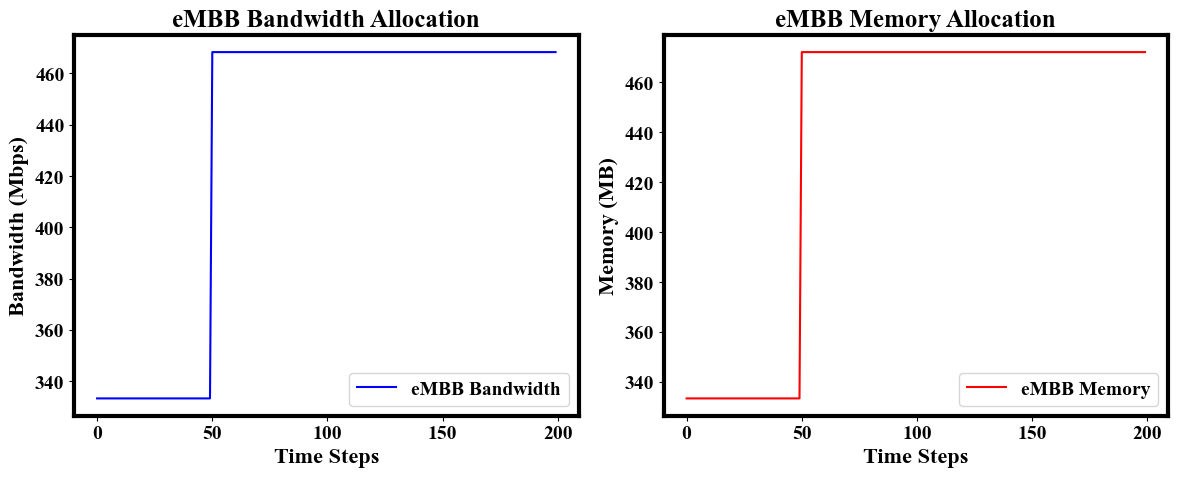

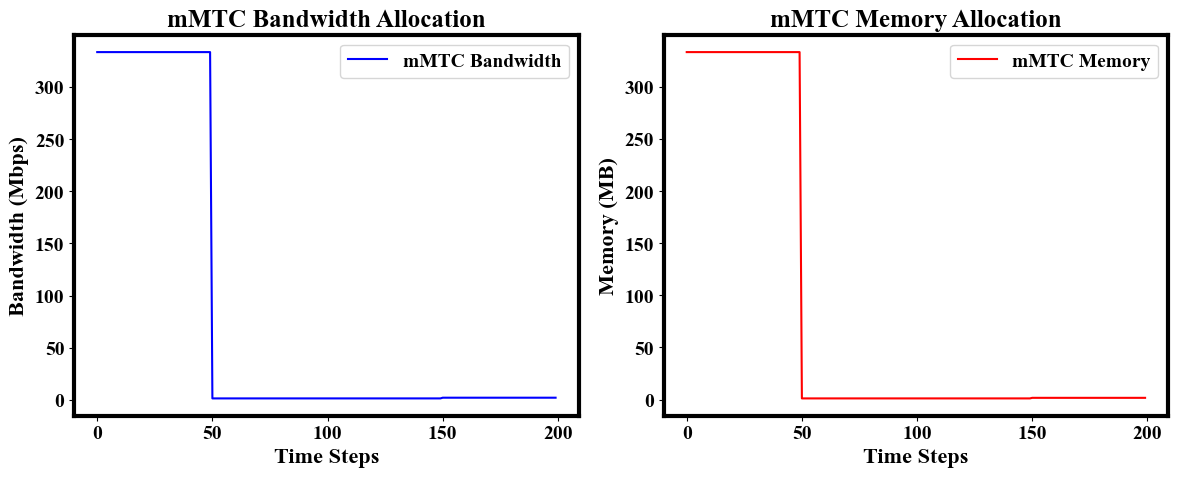

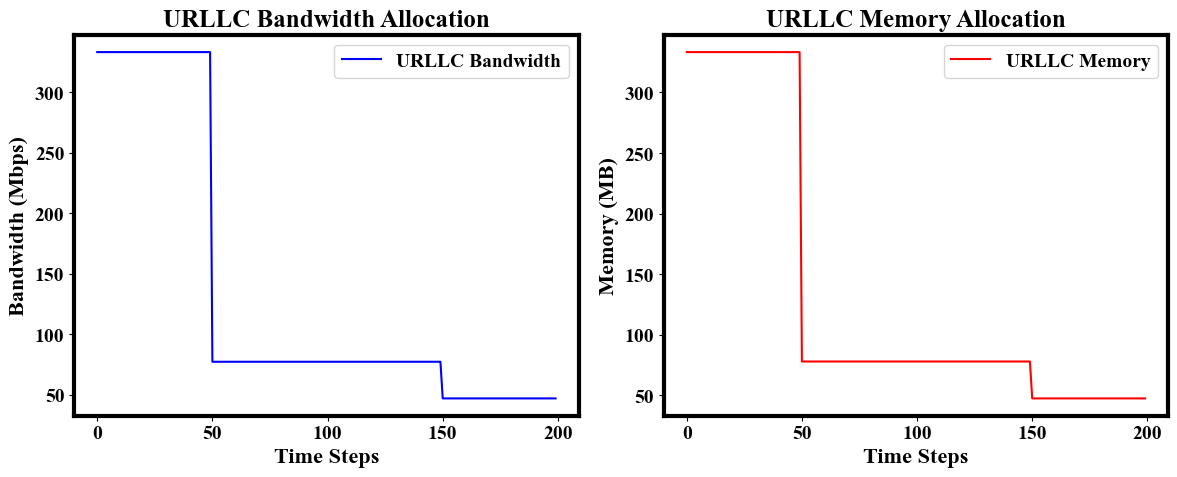

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define resource constraints
total_bandwidth = 1000  # Total available bandwidth in Mbps
total_memory = 1000     # Total available memory in MB

# Define utility functions for each slice
def utility_embb(bandwidth, memory):
    return (0.6 * bandwidth + 0.4 * memory)

def utility_mmtc(bandwidth, memory):
    return (0.2 * bandwidth + 0.8 * memory)

def utility_urllc(bandwidth, memory):
    return (0.5 * bandwidth + 0.5 * memory)

# Function to normalize allocations
def normalize_allocations(allocations, total_resources):
    total_alloc = sum(allocations)
    if total_alloc == 0:
        return [0] * len(allocations)
    return [(alloc / total_alloc) * total_resources for alloc in allocations]

# Function to smooth allocations
def smooth_allocation(current, new, threshold=0.3):
    if abs(new - current) / current > threshold:
        return new
    return current

# Function to allocate resources using game theory with smoothing
def allocate_resources_game_theory(y_pred_inv_embb, y_pred_inv_mmtc, y_pred_inv_urllc, update_interval=50):
    time_steps = len(y_pred_inv_embb)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}

    # Initial resource allocation
    prev_alloc_bandwidth = [total_bandwidth / 3] * 3
    prev_alloc_memory = [total_memory / 3] * 3

    # Last update time step
    last_update = 0

    for t in range(time_steps):
        if t - last_update >= update_interval:
            last_update = t

            traffic_embb = y_pred_inv_embb[t]
            traffic_mmtc = y_pred_inv_mmtc[t]
            traffic_urllc = y_pred_inv_urllc[t]

            # Initial allocation requests based on traffic volume
            req_bandwidth = [traffic_embb * 2, traffic_mmtc * 0.5, traffic_urllc * 1]
            req_memory = [traffic_embb * 1, traffic_mmtc * 0.2, traffic_urllc * 0.5]

            # Normalize requests
            alloc_bandwidth = normalize_allocations(req_bandwidth, total_bandwidth)
            alloc_memory = normalize_allocations(req_memory, total_memory)

            # Compute utilities
            utilities = [
                utility_embb(alloc_bandwidth[0], alloc_memory[0]),
                utility_mmtc(alloc_bandwidth[1], alloc_memory[1]),
                utility_urllc(alloc_bandwidth[2], alloc_memory[2])
            ]

            # Adjust allocations based on utilities
            sum_utilities = sum(utilities)
            if sum_utilities > 0:
                alloc_bandwidth = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_bandwidth, utilities)]
                alloc_memory = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_memory, utilities)]

            # Smooth allocations
            smooth_bandwidth = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_bandwidth, alloc_bandwidth)]
            smooth_memory = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_memory, alloc_memory)]

            # Update previous allocations
            prev_alloc_bandwidth = smooth_bandwidth
            prev_alloc_memory = smooth_memory

        # Store allocations
        resource_allocations['eMBB'].append((prev_alloc_bandwidth[0], prev_alloc_memory[0]))
        resource_allocations['mMTC'].append((prev_alloc_bandwidth[1], prev_alloc_memory[1]))
        resource_allocations['URLLC'].append((prev_alloc_bandwidth[2], prev_alloc_memory[2]))

    return resource_allocations

# Example traffic predictions for 200 time steps
np.random.seed(42)  # For reproducible results
y_embb_pred_inv = np.random.randint(100, 200, 200)
y_mmtc_pred_inv = np.random.randint(10, 50, 200)
y_urllc_pred_inv = np.random.randint(50, 100, 200)

# Allocate resources using game theory with smoothing and update interval
resource_allocations = allocate_resources_game_theory(y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv)

# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    memory_allocations = [alloc[1] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))
    
    plt.figure(figsize=(12, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # Plot memory allocations
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations
plot_resource_allocations(resource_allocations['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations['URLLC'], 'URLLC')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define resource constraints
total_bandwidth = 1000  # Total available bandwidth in Mbps
total_memory = 1000     # Total available memory in MB

# Define utility functions for each slice
def utility_embb(bandwidth, memory):
    return (0.6 * bandwidth + 0.4 * memory)

def utility_mmtc(bandwidth, memory):
    return (0.2 * bandwidth + 0.8 * memory)

def utility_urllc(bandwidth, memory):
    return (0.5 * bandwidth + 0.5 * memory)

# Function to normalize allocations
def normalize_allocations(allocations, total_resources):
    total_alloc = sum(allocations)
    if total_alloc == 0:
        return [0] * len(allocations)
    return [(alloc / total_alloc) * total_resources for alloc in allocations]

# Function to smooth allocations
def smooth_allocation(current, new, threshold=0.3):
    if abs(new - current) / current > threshold:
        return new
    return current

# Function to allocate resources using game theory with smoothing
def allocate_resources_game_theory(y_pred_inv_embb, y_pred_inv_mmtc, y_pred_inv_urllc, update_interval=10):
    time_steps = len(y_pred_inv_embb)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}

    # Initial resource allocation
    prev_alloc_bandwidth = [total_bandwidth / 3] * 3
    prev_alloc_memory = [total_memory / 3] * 3

    # Last update time step
    last_update = 0

    for t in range(time_steps):
        if t - last_update >= update_interval:
            last_update = t

            traffic_embb = y_pred_inv_embb[t]
            traffic_mmtc = y_pred_inv_mmtc[t]
            traffic_urllc = y_pred_inv_urllc[t]

            # Initial allocation requests based on traffic volume
            req_bandwidth = [traffic_embb * 2, traffic_mmtc * 0.5, traffic_urllc * 1]
            req_memory = [traffic_embb * 1, traffic_mmtc * 0.2, traffic_urllc * 0.5]

            # Normalize requests
            alloc_bandwidth = normalize_allocations(req_bandwidth, total_bandwidth)
            alloc_memory = normalize_allocations(req_memory, total_memory)

            # Compute utilities
            utilities = [
                utility_embb(alloc_bandwidth[0], alloc_memory[0]),
                utility_mmtc(alloc_bandwidth[1], alloc_memory[1]),
                utility_urllc(alloc_bandwidth[2], alloc_memory[2])
            ]

            # Adjust allocations based on utilities
            sum_utilities = sum(utilities)
            if sum_utilities > 0:
                alloc_bandwidth = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_bandwidth, utilities)]
                alloc_memory = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_memory, utilities)]

            # Smooth allocations
            smooth_bandwidth = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_bandwidth, alloc_bandwidth)]
            smooth_memory = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_memory, alloc_memory)]

            # Update previous allocations
            prev_alloc_bandwidth = smooth_bandwidth
            prev_alloc_memory = smooth_memory

        # Store allocations
        resource_allocations['eMBB'].append((prev_alloc_bandwidth[0], prev_alloc_memory[0]))
        resource_allocations['mMTC'].append((prev_alloc_bandwidth[1], prev_alloc_memory[1]))
        resource_allocations['URLLC'].append((prev_alloc_bandwidth[2], prev_alloc_memory[2]))

    return resource_allocations

# Example traffic predictions for 200 time steps
np.random.seed(42)  # For reproducible results
y_embb_pred_inv = np.random.randint(100, 200, 200)
y_mmtc_pred_inv = np.random.randint(10, 50, 200)
y_urllc_pred_inv = np.random.randint(50, 100, 200)

# Allocate resources using game theory with smoothing and update interval
resource_allocations = allocate_resources_game_theory(y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv, update_interval=10)

# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    memory_allocations = [alloc[1] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))
    
    plt.figure(figsize=(12, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # Plot memory allocations
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations
plot_resource_allocations(resource_allocations['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations['URLLC'], 'URLLC')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define resource constraints
total_bandwidth = 1000  # Total available bandwidth in Mbps
total_memory = 1000     # Total available memory in MB

# Define utility functions for each slice
def utility_embb(bandwidth, memory):
    return (0.6 * bandwidth + 0.4 * memory)

def utility_mmtc(bandwidth, memory):
    return (0.2 * bandwidth + 0.8 * memory)

def utility_urllc(bandwidth, memory):
    return (0.5 * bandwidth + 0.5 * memory)

# Function to normalize allocations
def normalize_allocations(allocations, total_resources):
    total_alloc = sum(allocations)
    if total_alloc == 0:
        return [0] * len(allocations)
    return [(alloc / total_alloc) * total_resources for alloc in allocations]

# Function to smooth allocations
def smooth_allocation(current, new, threshold=0.3):
    if abs(new - current) / current > threshold:
        return new
    return current

# Function to allocate resources using game theory with smoothing
def allocate_resources_game_theory(y_pred_inv_embb, y_pred_inv_mmtc, y_pred_inv_urllc, update_interval=5):
    time_steps = len(y_pred_inv_embb)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}

    # Initial resource allocation
    prev_alloc_bandwidth = [total_bandwidth / 3] * 3
    prev_alloc_memory = [total_memory / 3] * 3

    # Last update time step
    last_update = 0

    for t in range(time_steps):
        if t - last_update >= update_interval:
            last_update = t

            traffic_embb = y_pred_inv_embb[t]
            traffic_mmtc = y_pred_inv_mmtc[t]
            traffic_urllc = y_pred_inv_urllc[t]

            # Initial allocation requests based on traffic volume
            req_bandwidth = [traffic_embb * 2, traffic_mmtc * 0.5, traffic_urllc * 1]
            req_memory = [traffic_embb * 1, traffic_mmtc * 0.2, traffic_urllc * 0.5]

            # Normalize requests
            alloc_bandwidth = normalize_allocations(req_bandwidth, total_bandwidth)
            alloc_memory = normalize_allocations(req_memory, total_memory)

            # Compute utilities
            utilities = [
                utility_embb(alloc_bandwidth[0], alloc_memory[0]),
                utility_mmtc(alloc_bandwidth[1], alloc_memory[1]),
                utility_urllc(alloc_bandwidth[2], alloc_memory[2])
            ]

            # Adjust allocations based on utilities
            sum_utilities = sum(utilities)
            if sum_utilities > 0:
                alloc_bandwidth = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_bandwidth, utilities)]
                alloc_memory = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_memory, utilities)]

            # Smooth allocations
            smooth_bandwidth = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_bandwidth, alloc_bandwidth)]
            smooth_memory = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_memory, alloc_memory)]

            # Update previous allocations
            prev_alloc_bandwidth = smooth_bandwidth
            prev_alloc_memory = smooth_memory

        # Store allocations
        resource_allocations['eMBB'].append((prev_alloc_bandwidth[0], prev_alloc_memory[0]))
        resource_allocations['mMTC'].append((prev_alloc_bandwidth[1], prev_alloc_memory[1]))
        resource_allocations['URLLC'].append((prev_alloc_bandwidth[2], prev_alloc_memory[2]))

    return resource_allocations

# Example traffic predictions for 200 time steps
np.random.seed(42)  # For reproducible results
y_embb_pred_inv = np.random.randint(100, 200, 200)
y_mmtc_pred_inv = np.random.randint(10, 50, 200)
y_urllc_pred_inv = np.random.randint(50, 100, 200)

# Allocate resources using game theory with smoothing and update interval
resource_allocations = allocate_resources_game_theory(y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv, update_interval=5)

# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    memory_allocations = [alloc[1] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))
    
    plt.figure(figsize=(12, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # Plot memory allocations
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations
plot_resource_allocations(resource_allocations['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations['URLLC'], 'URLLC')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define resource constraints
total_bandwidth = 1000  # Total available bandwidth in Mbps
total_memory = 1000     # Total available memory in MB

# Define utility functions for each slice
def utility_embb(bandwidth, memory):
    return (0.6 * bandwidth + 0.4 * memory)

def utility_mmtc(bandwidth, memory):
    return (0.2 * bandwidth + 0.8 * memory)

def utility_urllc(bandwidth, memory):
    return (0.5 * bandwidth + 0.5 * memory)

# Function to normalize allocations with minimum constraints
def normalize_allocations_with_min(allocations, total_resources, min_percentage=0.2):
    min_resources = total_resources * min_percentage
    allocations = np.maximum(allocations, min_resources)
    total_alloc = sum(allocations)
    if total_alloc == 0:
        return [0] * len(allocations)
    return [(alloc / total_alloc) * total_resources for alloc in allocations]

# Function to smooth allocations
def smooth_allocation(current, new, threshold=0.3):
    if abs(new - current) / current > threshold:
        return new
    return current

# Function to allocate resources using game theory with smoothing and minimum constraints
def allocate_resources_game_theory(y_pred_inv_embb, y_pred_inv_mmtc, y_pred_inv_urllc, update_interval=5):
    time_steps = len(y_pred_inv_embb)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}

    # Initial resource allocation
    prev_alloc_bandwidth = [total_bandwidth / 3] * 3
    prev_alloc_memory = [total_memory / 3] * 3

    # Last update time step
    last_update = 0

    for t in range(time_steps):
        if t - last_update >= update_interval:
            last_update = t

            traffic_embb = y_pred_inv_embb[t]
            traffic_mmtc = y_pred_inv_mmtc[t]
            traffic_urllc = y_pred_inv_urllc[t]

            # Initial allocation requests based on traffic volume
            req_bandwidth = [traffic_embb * 2, traffic_mmtc * 0.5, traffic_urllc * 1]
            req_memory = [traffic_embb * 1, traffic_mmtc * 0.2, traffic_urllc * 0.5]

            # Normalize requests with minimum constraints
            alloc_bandwidth = normalize_allocations_with_min(req_bandwidth, total_bandwidth)
            alloc_memory = normalize_allocations_with_min(req_memory, total_memory)

            # Compute utilities
            utilities = [
                utility_embb(alloc_bandwidth[0], alloc_memory[0]),
                utility_mmtc(alloc_bandwidth[1], alloc_memory[1]),
                utility_urllc(alloc_bandwidth[2], alloc_memory[2])
            ]

            # Adjust allocations based on utilities
            sum_utilities = sum(utilities)
            if sum_utilities > 0:
                alloc_bandwidth = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_bandwidth, utilities)]
                alloc_memory = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_memory, utilities)]

            # Smooth allocations
            smooth_bandwidth = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_bandwidth, alloc_bandwidth)]
            smooth_memory = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_memory, alloc_memory)]

            # Update previous allocations
            prev_alloc_bandwidth = smooth_bandwidth
            prev_alloc_memory = smooth_memory

        # Store allocations
        resource_allocations['eMBB'].append((prev_alloc_bandwidth[0], prev_alloc_memory[0]))
        resource_allocations['mMTC'].append((prev_alloc_bandwidth[1], prev_alloc_memory[1]))
        resource_allocations['URLLC'].append((prev_alloc_bandwidth[2], prev_alloc_memory[2]))

    return resource_allocations

# Example traffic predictions for 200 time steps
np.random.seed(42)  # For reproducible results
y_embb_pred_inv = np.random.randint(100, 200, 200)
y_mmtc_pred_inv = np.random.randint(10, 50, 200)
y_urllc_pred_inv = np.random.randint(50, 100, 200)

# Allocate resources using game theory with smoothing and update interval
resource_allocations = allocate_resources_game_theory(y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv, update_interval=5)

# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    memory_allocations = [alloc[1] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))
    
    plt.figure(figsize=(12, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # Plot memory allocations
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations
plot_resource_allocations(resource_allocations['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations['URLLC'], 'URLLC')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define resource constraints
total_bandwidth = 1000  # Total available bandwidth in Mbps
total_memory = 1000     # Total available memory in MB

# Define utility functions for each slice
def utility_embb(bandwidth, memory):
    return (0.6 * bandwidth + 0.4 * memory)

def utility_mmtc(bandwidth, memory):
    return (0.2 * bandwidth + 0.8 * memory)

def utility_urllc(bandwidth, memory):
    return (0.5 * bandwidth + 0.5 * memory)

# Function to normalize allocations with minimum constraints
def normalize_allocations_with_min(allocations, total_resources, min_percentage=0.2):
    min_resources = total_resources * min_percentage
    allocations = np.maximum(allocations, min_resources)
    
    excess_allocation = sum(allocations) - total_resources
    if excess_allocation > 0:
        for i in range(len(allocations)):
            if allocations[i] > min_resources:
                alloc_reduction = min(excess_allocation, allocations[i] - min_resources)
                allocations[i] -= alloc_reduction
                excess_allocation -= alloc_reduction
                if excess_allocation <= 0:
                    break
    return allocations

# Function to smooth allocations
def smooth_allocation(current, new, threshold=0.3):
    if abs(new - current) / current > threshold:
        return new
    return current

# Function to allocate resources using game theory with smoothing and minimum constraints
def allocate_resources_game_theory(y_pred_inv_embb, y_pred_inv_mmtc, y_pred_inv_urllc, update_interval=5):
    time_steps = len(y_pred_inv_embb)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}

    # Initial resource allocation
    prev_alloc_bandwidth = [total_bandwidth / 3] * 3
    prev_alloc_memory = [total_memory / 3] * 3

    # Last update time step
    last_update = 0

    for t in range(time_steps):
        if t - last_update >= update_interval:
            last_update = t

            traffic_embb = y_pred_inv_embb[t]
            traffic_mmtc = y_pred_inv_mmtc[t]
            traffic_urllc = y_pred_inv_urllc[t]

            # Initial allocation requests based on traffic volume
            req_bandwidth = [traffic_embb * 2, traffic_mmtc * 0.5, traffic_urllc * 1]
            req_memory = [traffic_embb * 1, traffic_mmtc * 0.2, traffic_urllc * 0.5]

            # Normalize requests with minimum constraints
            alloc_bandwidth = normalize_allocations_with_min(req_bandwidth, total_bandwidth)
            alloc_memory = normalize_allocations_with_min(req_memory, total_memory)

            # Compute utilities
            utilities = [
                utility_embb(alloc_bandwidth[0], alloc_memory[0]),
                utility_mmtc(alloc_bandwidth[1], alloc_memory[1]),
                utility_urllc(alloc_bandwidth[2], alloc_memory[2])
            ]

            # Adjust allocations based on utilities
            sum_utilities = sum(utilities)
            if sum_utilities > 0:
                alloc_bandwidth = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_bandwidth, utilities)]
                alloc_memory = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_memory, utilities)]

            # Smooth allocations
            smooth_bandwidth = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_bandwidth, alloc_bandwidth)]
            smooth_memory = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_memory, alloc_memory)]

            # Update previous allocations
            prev_alloc_bandwidth = smooth_bandwidth
            prev_alloc_memory = smooth_memory

        # Store allocations
        resource_allocations['eMBB'].append((prev_alloc_bandwidth[0], prev_alloc_memory[0]))
        resource_allocations['mMTC'].append((prev_alloc_bandwidth[1], prev_alloc_memory[1]))
        resource_allocations['URLLC'].append((prev_alloc_bandwidth[2], prev_alloc_memory[2]))

    return resource_allocations

# Example traffic predictions for 200 time steps
np.random.seed(42)  # For reproducible results
y_embb_pred_inv = np.random.randint(100, 200, 200)
y_mmtc_pred_inv = np.random.randint(10, 50, 200)
y_urllc_pred_inv = np.random.randint(50, 100, 200)

# Allocate resources using game theory with smoothing and update interval
resource_allocations = allocate_resources_game_theory(y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv, update_interval=5)

# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    memory_allocations = [alloc[1] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))
    
    plt.figure(figsize=(12, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # Plot memory allocations
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations
plot_resource_allocations(resource_allocations['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations['URLLC'], 'URLLC')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define resource constraints
total_bandwidth = 1000  # Total available bandwidth in Mbps
total_memory = 1000     # Total available memory in MB

# Define utility functions for each slice
def utility_embb(bandwidth, memory):
    return (0.6 * bandwidth + 0.4 * memory)

def utility_mmtc(bandwidth, memory):
    return (0.2 * bandwidth + 0.8 * memory)

def utility_urllc(bandwidth, memory):
    return (0.5 * bandwidth + 0.5 * memory)

# Function to normalize allocations
def normalize_allocations(allocations, total_resources):
    total_alloc = sum(allocations)
    if total_alloc == 0:
        return [0] * len(allocations)
    return [(alloc / total_alloc) * total_resources for alloc in allocations]

# Function to enforce minimum allocation constraints
def enforce_min_allocation(allocations, min_allocation):
    adjusted_allocations = []
    total_alloc = sum(allocations)
    excess_resources = 0

    for alloc in allocations:
        if alloc < min_allocation:
            excess_resources += min_allocation - alloc
            adjusted_allocations.append(min_allocation)
        else:
            adjusted_allocations.append(alloc)
    
    if excess_resources > 0:
        for i in range(len(adjusted_allocations)):
            if adjusted_allocations[i] > min_allocation:
                available_to_reduce = adjusted_allocations[i] - min_allocation
                reduction = min(excess_resources, available_to_reduce)
                adjusted_allocations[i] -= reduction
                excess_resources -= reduction
    
    return adjusted_allocations

# Function to smooth allocations
def smooth_allocation(current, new, threshold=0.3):
    if abs(new - current) / current > threshold:
        return new
    return current

# Function to allocate resources using game theory with smoothing and minimum constraints
def allocate_resources_game_theory(y_pred_inv_embb, y_pred_inv_mmtc, y_pred_inv_urllc):
    time_steps = len(y_pred_inv_embb)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}
    min_bandwidth_allocation = total_bandwidth * 0.2
    min_memory_allocation = total_memory * 0.2

    # Initial resource allocation
    prev_alloc_bandwidth = [total_bandwidth / 3] * 3
    prev_alloc_memory = [total_memory / 3] * 3

    for t in range(time_steps):
        traffic_embb = y_pred_inv_embb[t]
        traffic_mmtc = y_pred_inv_mmtc[t]
        traffic_urllc = y_pred_inv_urllc[t]
        
        # Initial allocation requests based on traffic volume
        req_bandwidth = [traffic_embb * 2, traffic_mmtc * 0.5, traffic_urllc * 1]
        req_memory = [traffic_embb * 1, traffic_mmtc * 0.2, traffic_urllc * 0.5]

        # Normalize requests
        alloc_bandwidth = normalize_allocations(req_bandwidth, total_bandwidth)
        alloc_memory = normalize_allocations(req_memory, total_memory)
        
        # Enforce minimum allocation constraints
        alloc_bandwidth = enforce_min_allocation(alloc_bandwidth, min_bandwidth_allocation)
        alloc_memory = enforce_min_allocation(alloc_memory, min_memory_allocation)
        
        # Compute utilities
        utilities = [
            utility_embb(alloc_bandwidth[0], alloc_memory[0]),
            utility_mmtc(alloc_bandwidth[1], alloc_memory[1]),
            utility_urllc(alloc_bandwidth[2], alloc_memory[2])
        ]
        
        # Adjust allocations based on utilities
        sum_utilities = sum(utilities)
        if sum_utilities > 0:
            alloc_bandwidth = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_bandwidth, utilities)]
            alloc_memory = [alloc * (util / sum_utilities) for alloc, util in zip(alloc_memory, utilities)]
        
        # Smooth allocations
        smooth_bandwidth = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_bandwidth, alloc_bandwidth)]
        smooth_memory = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_memory, alloc_memory)]
        
        # Store allocations
        resource_allocations['eMBB'].append((smooth_bandwidth[0], smooth_memory[0]))
        resource_allocations['mMTC'].append((smooth_bandwidth[1], smooth_memory[1]))
        resource_allocations['URLLC'].append((smooth_bandwidth[2], smooth_memory[2]))
        
        # Update previous allocations
        prev_alloc_bandwidth = smooth_bandwidth
        prev_alloc_memory = smooth_memory
    
    return resource_allocations

# Example traffic predictions for 200 time steps
np.random.seed(42)  # For reproducible results
y_embb_pred_inv = np.random.randint(100, 200, 200)
y_mmtc_pred_inv = np.random.randint(10, 50, 200)
y_urllc_pred_inv = np.random.randint(50, 100, 200)

# Allocate resources using game theory with smoothing and minimum constraints
resource_allocations = allocate_resources_game_theory(y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv)

# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    memory_allocations = [alloc[1] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))
    
    plt.figure(figsize=(12, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # Plot memory allocations
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations
plot_resource_allocations(resource_allocations['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations['URLLC'], 'URLLC')


In [ ]:
## Intentionally left blank

In [ ]:
## Intentionally left blank

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Example traffic predictions for 200 time steps
np.random.seed(42)  # For reproducible results
y_embb_pred_inv = np.random.randint(100, 200, 200)
y_mmtc_pred_inv = np.random.randint(10, 50, 200)
y_urllc_pred_inv = np.random.randint(50, 100, 200)

# Combine traffic predictions into a single DataFrame
traffic_data = pd.DataFrame({
    'eMBB': y_embb_pred_inv,
    'mMTC': y_mmtc_pred_inv,
    'URLLC': y_urllc_pred_inv
})

# Normalize the data
scaler = MinMaxScaler()
traffic_data_scaled = scaler.fit_transform(traffic_data)

# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

time_step = 5
X, y = create_dataset(traffic_data_scaled, time_step)

# Split into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 3)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(3))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1)


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Function to normalize allocations
def normalize_allocations(allocations, total_resources):
    total_alloc = sum(allocations)
    if total_alloc == 0:
        return [0] * len(allocations)
    return [(alloc / total_alloc) * total_resources for alloc in allocations]

# Function to enforce minimum allocation constraints
def enforce_min_allocation(allocations, min_allocation):
    adjusted_allocations = []
    total_alloc = sum(allocations)
    excess_resources = 0

    for alloc in allocations:
        if alloc < min_allocation:
            excess_resources += min_allocation - alloc
            adjusted_allocations.append(min_allocation)
        else:
            adjusted_allocations.append(alloc)
    
    if excess_resources > 0:
        for i in range(len(adjusted_allocations)):
            if adjusted_allocations[i] > min_allocation:
                available_to_reduce = adjusted_allocations[i] - min_allocation
                reduction = min(excess_resources, available_to_reduce)
                adjusted_allocations[i] -= reduction
                excess_resources -= reduction
    
    return adjusted_allocations

# Function to smooth allocations
def smooth_allocation(current, new, threshold=0.3):
    if abs(new - current) / current > threshold:
        return new
    return current

# Function to allocate resources using game theory with smoothing and minimum constraints
def allocate_resources_game_theory(predictions, total_bandwidth, total_memory):
    time_steps = len(predictions)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}
    min_bandwidth_allocation = total_bandwidth * 0.2
    min_memory_allocation = total_memory * 0.2

    # Initial resource allocation
    prev_alloc_bandwidth = [total_bandwidth / 3] * 3
    prev_alloc_memory = [total_memory / 3] * 3

    for t in range(time_steps):
        pred = predictions[t]
        
        # Initial allocation requests based on traffic volume
        req_bandwidth = [pred[0] * 2, pred[1] * 0.5, pred[2] * 1]
        req_memory = [pred[0] * 1, pred[1] * 0.2, pred[2] * 0.5]

        # Normalize requests
        alloc_bandwidth = normalize_allocations(req_bandwidth, total_bandwidth)
        alloc_memory = normalize_allocations(req_memory, total_memory)
        
        # Enforce minimum allocation constraints
        alloc_bandwidth = enforce_min_allocation(alloc_bandwidth, min_bandwidth_allocation)
        alloc_memory = enforce_min_allocation(alloc_memory, min_memory_allocation)
        
        # Smooth allocations
        smooth_bandwidth = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_bandwidth, alloc_bandwidth)]
        smooth_memory = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_memory, alloc_memory)]
        
        # Store allocations
        resource_allocations['eMBB'].append((smooth_bandwidth[0], smooth_memory[0]))
        resource_allocations['mMTC'].append((smooth_bandwidth[1], smooth_memory[1]))
        resource_allocations['URLLC'].append((smooth_bandwidth[2], smooth_memory[2]))
        
        # Update previous allocations
        prev_alloc_bandwidth = smooth_bandwidth
        prev_alloc_memory = smooth_memory
    
    return resource_allocations

# Allocate resources using game theory with smoothing and minimum constraints
resource_allocations_test = allocate_resources_game_theory(test_predict, total_bandwidth, total_memory)


In [ ]:
# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    memory_allocations = [alloc[1] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))
    
    plt.figure(figsize=(12, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # Plot memory allocations
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations for test set
plot_resource_allocations(resource_allocations_test['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations_test['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations_test['URLLC'], 'URLLC')

In [ ]:
# Intentionally left blank

In [ ]:
# Intentionally left blank

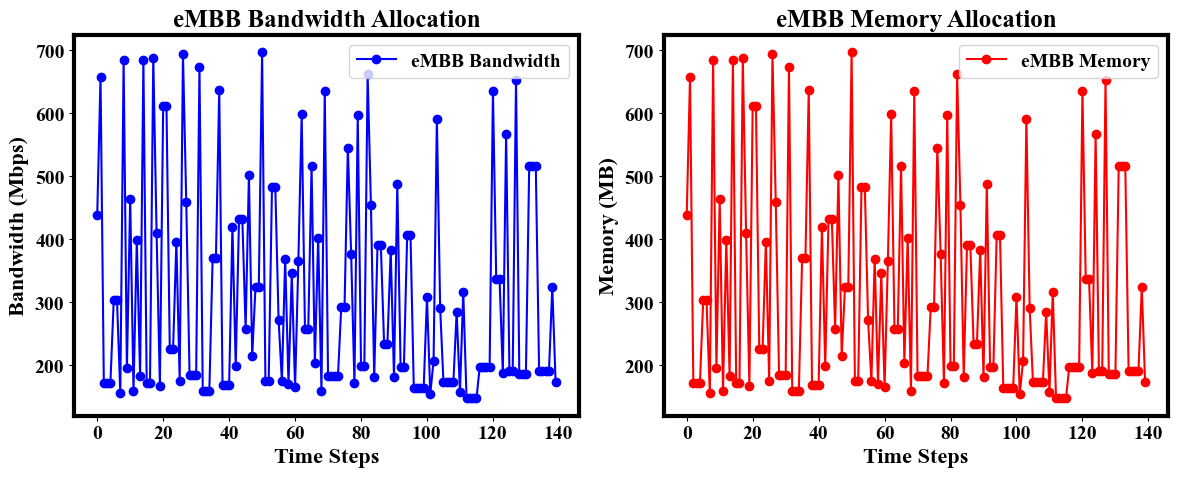

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (140,) + inhomogeneous part.

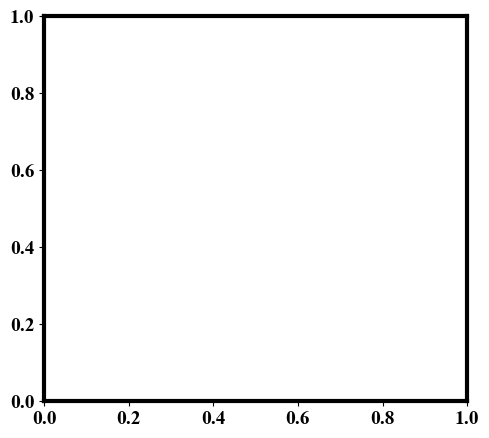

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define resource constraints
total_bandwidth = 1000  # Total available bandwidth in Mbps
total_memory = 1000     # Total available memory in MB

# Function to normalize allocations
def normalize_allocations(allocations, total_resources):
    total_alloc = sum(allocations)
    if total_alloc == 0:
        return [0] * len(allocations)
    return [(alloc / total_alloc) * total_resources for alloc in allocations]

# Function to smooth allocations
def smooth_allocation(current, new, threshold=0.3):
    if abs(new - current) / current > threshold:
        return new
    return current

# Allocate resources proportionally based on traffic predictions
def allocate_resources(embb_traffic, mmtc_traffic, urllc_traffic):
    time_steps = len(embb_traffic)
    resource_allocations = {'eMBB': [], 'mMTC': [], 'URLLC': []}

    # Initial resource allocation
    prev_alloc_bandwidth = [total_bandwidth / 3] * 3
    prev_alloc_memory = [total_memory / 3] * 3

    for t in range(time_steps):
        # Calculate total traffic
        total_traffic = embb_traffic[t] + mmtc_traffic[t] + urllc_traffic[t]

        # Allocate resources proportionally
        alloc_bandwidth = [
            (embb_traffic[t] / total_traffic) * total_bandwidth,
            (mmtc_traffic[t] / total_traffic) * total_bandwidth,
            (urllc_traffic[t] / total_traffic) * total_bandwidth
        ]
        alloc_memory = [
            (embb_traffic[t] / total_traffic) * total_memory,
            (mmtc_traffic[t] / total_traffic) * total_memory,
            (urllc_traffic[t] / total_traffic) * total_memory
        ]

        # Ensure no slice gets less than 20% of the resources
        min_resource_ratio = 0.2
        for i in range(3):
            if alloc_bandwidth[i] < total_bandwidth * min_resource_ratio:
                alloc_bandwidth[i] = total_bandwidth * min_resource_ratio
            if alloc_memory[i] < total_memory * min_resource_ratio:
                alloc_memory[i] = total_memory * min_resource_ratio

        # Normalize requests
        alloc_bandwidth = normalize_allocations(alloc_bandwidth, total_bandwidth)
        alloc_memory = normalize_allocations(alloc_memory, total_memory)

        # Smooth allocations
        smooth_bandwidth = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_bandwidth, alloc_bandwidth)]
        smooth_memory = [smooth_allocation(prev, curr) for prev, curr in zip(prev_alloc_memory, alloc_memory)]

        # Store allocations
        resource_allocations['eMBB'].append((smooth_bandwidth[0], smooth_memory[0]))
        resource_allocations['mMTC'].append((smooth_bandwidth[1], smooth_memory[1]))
        resource_allocations['URLLC'].append((smooth_bandwidth[2], smooth_memory[2]))

        # Update previous allocations
        prev_alloc_bandwidth = smooth_bandwidth
        prev_alloc_memory = smooth_memory

    return resource_allocations

# Example traffic predictions for 200 time steps (use your actual predictions)
y_embb_pred_inv =  y_embb_pred_inv
y_mmtc_pred_inv =  y_mmtc_pred_inv
y_urllc_pred_inv =  y_urllc_pred_inv

# Allocate resources based on traffic predictions
resource_allocations = allocate_resources(y_embb_pred_inv, y_mmtc_pred_inv, y_urllc_pred_inv)

# Function to plot resource allocations
def plot_resource_allocations(resource_allocations, slice_name):
    bandwidth_allocations = [alloc[0] for alloc in resource_allocations]
    memory_allocations = [alloc[1] for alloc in resource_allocations]

    time_steps = range(len(resource_allocations))

    plt.figure(figsize=(12, 5))

    # Plot bandwidth allocations
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, bandwidth_allocations, label=f"{slice_name} Bandwidth", color='blue', marker='o')
    plt.xlabel('Time Steps')
    plt.ylabel('Bandwidth (Mbps)')
    plt.title(f'{slice_name} Bandwidth Allocation')
    plt.legend()

    # Plot memory allocations
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, memory_allocations, label=f"{slice_name} Memory", color='red', marker='o')
    plt.xlabel('Time Steps')
    plt.ylabel('Memory (MB)')
    plt.title(f'{slice_name} Memory Allocation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the resources allocations for each slice
plot_resource_allocations(resource_allocations['eMBB'], 'eMBB')
plot_resource_allocations(resource_allocations['mMTC'], 'mMTC')
plot_resource_allocations(resource_allocations['URLLC'], 'URLLC')
